In [25]:
import copy
 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing

In [26]:
#Read data
data = fetch_california_housing()
X, y = data.data, data.target
 
# train-test split for model evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)
 
# Convert to 2D PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

In [27]:
X.shape

(20640, 8)

In [28]:
y.shape

(20640,)

In [29]:
print(X[:5])

[[ 8.32520000e+00  4.10000000e+01  6.98412698e+00  1.02380952e+00
   3.22000000e+02  2.55555556e+00  3.78800000e+01 -1.22230000e+02]
 [ 8.30140000e+00  2.10000000e+01  6.23813708e+00  9.71880492e-01
   2.40100000e+03  2.10984183e+00  3.78600000e+01 -1.22220000e+02]
 [ 7.25740000e+00  5.20000000e+01  8.28813559e+00  1.07344633e+00
   4.96000000e+02  2.80225989e+00  3.78500000e+01 -1.22240000e+02]
 [ 5.64310000e+00  5.20000000e+01  5.81735160e+00  1.07305936e+00
   5.58000000e+02  2.54794521e+00  3.78500000e+01 -1.22250000e+02]
 [ 3.84620000e+00  5.20000000e+01  6.28185328e+00  1.08108108e+00
   5.65000000e+02  2.18146718e+00  3.78500000e+01 -1.22250000e+02]]


In [30]:
print(y[:5])

[4.526 3.585 3.521 3.413 3.422]


In [31]:
# Define the model
model = nn.Sequential(
    nn.Linear(8, 24),
    nn.ReLU(),
    nn.Linear(24, 12),
    nn.ReLU(),
    nn.Linear(12, 6),
    nn.ReLU(),
    nn.Linear(6, 1)
)

In [32]:
# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)
 
n_epochs = 20  # number of epochs to run
batch_size = 32  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

In [33]:
batch_start

tensor([    0,    32,    64,    96,   128,   160,   192,   224,   256,   288,
          320,   352,   384,   416,   448,   480,   512,   544,   576,   608,
          640,   672,   704,   736,   768,   800,   832,   864,   896,   928,
          960,   992,  1024,  1056,  1088,  1120,  1152,  1184,  1216,  1248,
         1280,  1312,  1344,  1376,  1408,  1440,  1472,  1504,  1536,  1568,
         1600,  1632,  1664,  1696,  1728,  1760,  1792,  1824,  1856,  1888,
         1920,  1952,  1984,  2016,  2048,  2080,  2112,  2144,  2176,  2208,
         2240,  2272,  2304,  2336,  2368,  2400,  2432,  2464,  2496,  2528,
         2560,  2592,  2624,  2656,  2688,  2720,  2752,  2784,  2816,  2848,
         2880,  2912,  2944,  2976,  3008,  3040,  3072,  3104,  3136,  3168,
         3200,  3232,  3264,  3296,  3328,  3360,  3392,  3424,  3456,  3488,
         3520,  3552,  3584,  3616,  3648,  3680,  3712,  3744,  3776,  3808,
         3840,  3872,  3904,  3936,  3968,  4000,  4032,  4064, 

### Important Methods and functions
#### Workflow:
##### 1. We take an input batch from our training set on every iteration of the loop.
##### 2. We then run those through our model 
##### 3. compute the loss from the expected output 
##### 4. compute the gradients at every layer, through backpropogation.
##### 5. Finally, Use those gradients to perform the adjustment of the weights and bias


#### 1. optimizer.zero_grad() 
It turns out that the calculated gradients accumulate by default. if we didn’t zero the gradients at the end of the batch’s iteration, the next batch would have to deal with this batch’s gradients
We use zero_grad() to make sure they are reset to zero after we’re done with our loop
#### 2. loss.backward()
To compute the gradients, we call the loss.backward() method on the model
#### 3. Optimizer
###### Specify the type of Optimizer: SGD, Adam, RMSProp, Adagrad
###### optimizer.step():
Updates the parameters This should be called once the gradients for every neuron have been computed by invoking the loss.backward()


| Number | Step name | What does it do? | Code example |
| ----- | ----- | ----- | ----- |
| 1 | Forward pass | The model goes through all of the training data once, performing its `forward()` function calculations. | `model(x_train)` |
| 2 | Calculate the loss | The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are. | `loss = loss_fn(y_pred, y_train)` | 
| 3 | Zero gradients | The optimizers gradients are set to zero (they are accumulated by default) so they can be recalculated for the specific training step. | `optimizer.zero_grad()` |
| 4 | Perform backpropagation on the loss | Computes the gradient of the loss with respect for every model parameter to be updated  (each parameter with `requires_grad=True`). This is known as **backpropagation**, hence "backwards".  | `loss.backward()` |
| 5 | Update the optimizer (**gradient descent**) | Update the parameters with `requires_grad=True` with respect to the loss gradients in order to improve them. | `optimizer.step()` |

In [34]:
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
for epoch in range(n_epochs):
    print("epoch = ", epoch)
    model.train()
    for start in batch_start:
            # take a batch
        
        X_batch = X_train[start:start+batch_size]
        y_batch = y_train[start:start+batch_size]
            # forward pass
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
            # backward pass
        optimizer.zero_grad()
        loss.backward()
            # update weights
        optimizer.step()
    # evaluate accuracy at end of each epoch
    #model.eval -> model.train(mode = "false")
    #model.train(mode = "true") -> model.train()
    
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
 


epoch =  0
epoch =  1
epoch =  2
epoch =  3
epoch =  4
epoch =  5
epoch =  6
epoch =  7
epoch =  8
epoch =  9
epoch =  10
epoch =  11
epoch =  12
epoch =  13
epoch =  14
epoch =  15
epoch =  16
epoch =  17
epoch =  18
epoch =  19


MSE: 0.92
RMSE: 0.96


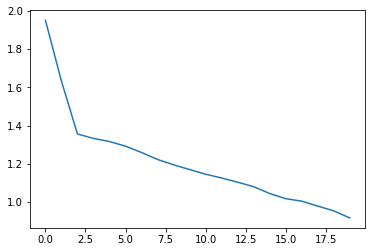

In [35]:
# restore model and return best accuracy
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

In [36]:
model.state_dict()

OrderedDict([('0.weight',
              tensor([[ 3.7714e-01,  1.5971e-02, -2.0707e-01, -1.1569e-01, -1.8699e-01,
                       -2.6116e-02,  1.7829e-01, -3.6978e-01],
                      [-1.2352e-01,  2.6976e-01,  1.0020e-01, -2.4690e-01, -1.5549e-01,
                       -3.3664e-01, -2.6560e-01, -4.1974e-02],
                      [ 1.4775e-01,  3.4136e-01, -9.6206e-02,  3.1159e-01,  2.1973e-01,
                       -1.1178e-02,  2.6602e-01, -2.7486e-01],
                      [ 1.3330e-01,  1.7281e-01, -1.1906e-01, -2.9414e-01, -2.3479e-01,
                       -1.8674e-01, -7.1625e-02,  2.6830e-01],
                      [-2.2476e-01, -6.3609e-02,  2.1294e-01,  7.0835e-02, -3.6250e-01,
                       -7.9187e-02, -3.0405e-01, -2.2493e-01],
                      [ 1.1758e-01,  1.7886e-02,  1.0034e-01, -2.0559e-01, -5.7700e-04,
                        3.1114e-01, -2.7431e-01,  1.2748e-01],
                      [ 4.7664e-01,  2.6252e-01,  2.0889e-01,  1.521